# PROBLEM STATEMENT
You are a data scientist employed by a taxi company to develop solutions based on advanced analytics to improve their bottom-line performance. You are given access to raw data and some guiding questions to conduct your analysis.
Data can be found at: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
Exploratory Analysis
1. What do the following distributions tell us?
a. Fare and tip amount
b. Number of passengers
c. Payment type
2. What are the top 5 busiest time of the day?
3. What are the top 5 busiest locations in the city?
4. What are the top 5 busiest routes in the city?
Open questions
5. Can you characterize trips by attributes such as distance, fare, pickup point?
6. Can you predict fare and tip amount of a trip?
7. If you are a taxi owner, how would you maximize earnings in a day?
8. If you own 10 taxis, how would you maximize your earnings?

**Data Information**
The yellow and green taxi trip records include fields capturing
pick-up and drop-off dates/times,
pick-up and drop-off locations,
trip distances,
itemized fares,
rate types,
payment types,
driver-reported passenger counts.
The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC)

__Information on taxis__:
Yellow Taxi: Yellow Medallion Taxicabs
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

__For Hire Vehicles (FHVs)__
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.

__Green Taxi: Street Hail Livery (SHL)__
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.

*Footnote: Here in this notebook we are considering  only the green taxis for the year of 2017 for the months of May to July 2017.*

**The data dictionary is given below**
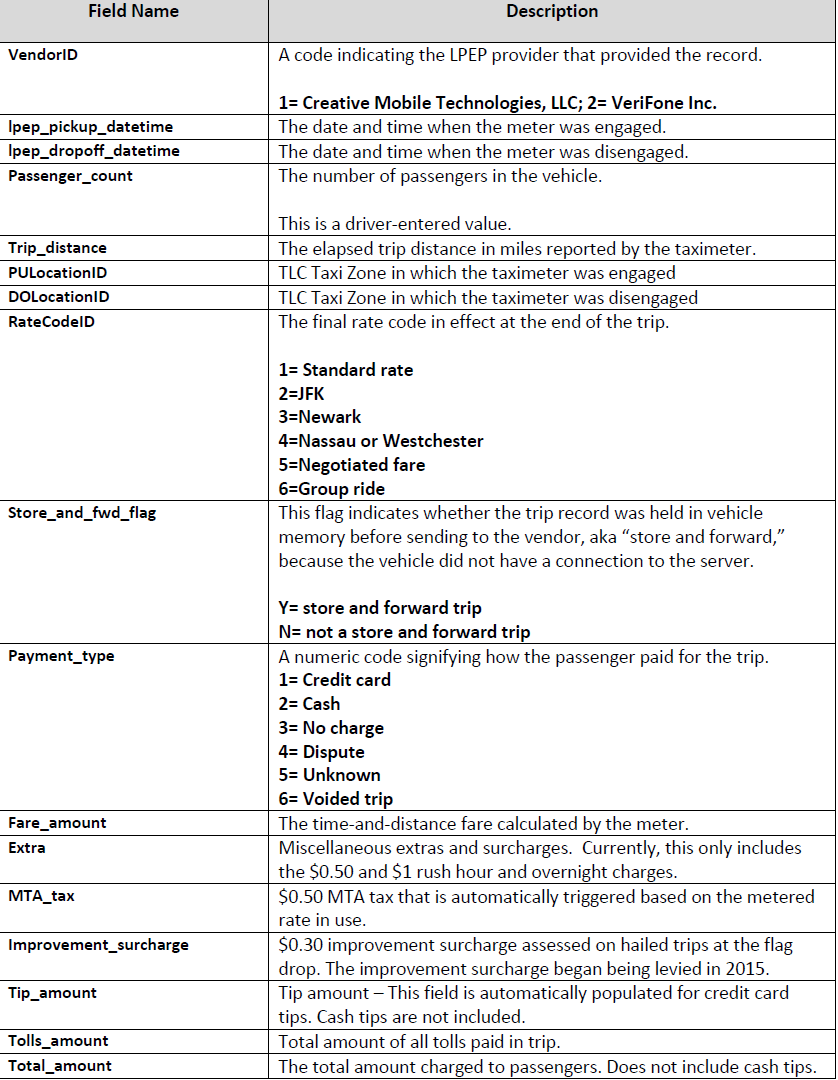

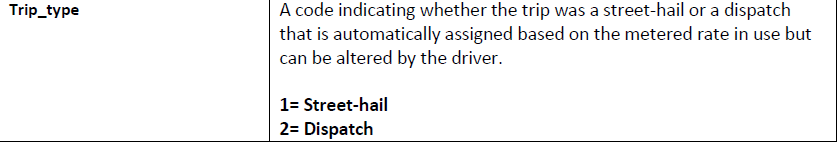

### Data Collection
We Have collected all yellow taxi trips data from may-2017 to July-2017

In [1]:
#The following libraries are imported for performing data analysis
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import seaborn as sns#Plots
import matplotlib.pylab as plt#Plots
import matplotlib  #Plots
from matplotlib import rcParams#Size of plots 
from PIL import Image
from pygeoexif import get_lat_lon
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [2]:
# now we will import some more libraries for data visualisation
# shape file is used for geometry and nontopological data
import shapefile
import matplotlib as mpl
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch
plt.style.use('ggplot')
%matplotlib inline
import shapely

In [3]:
from sqlalchemy import create_engine
nyc_database = create_engine('sqlite:///nyc_database_green_taxi_.db')

In [5]:
# Download the Trip Record Data
for month in range(5,8):
    urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/trip+data/"+ \
                               "green_tripdata_2017-{0:0=2d}.csv".format(month), 
                               "nyc.2017-{0:0=2d}.csv".format(month))

# Download the location Data
urllib.request.urlretrieve("https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip", "taxi_zones.zip")
with zipfile.ZipFile("taxi_zones.zip","r") as zip_ref:
    zip_ref.extractall("./shape")

In [4]:
df = pd.read_csv("nyc.2017-05.csv", nrows=10)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,2017-05-01 00:01:45,2017-05-01 00:20:40,N,1,223,129,1,2.63,13.0,0.5,0.5,0.0,0,NaN,0.3,14.3,2,1
1,2,2017-05-01 00:24:58,2017-05-01 00:38:29,N,1,256,225,1,1.45,10.0,0.5,0.5,0.0,0,NaN,0.3,11.3,2,1
2,2,2017-05-01 00:00:11,2017-05-01 00:06:42,N,1,75,163,1,2.80,9.5,0.5,0.5,0.0,0,NaN,0.3,10.8,2,1
3,2,2017-05-01 00:03:17,2017-05-01 00:14:40,N,1,7,129,1,2.48,10.5,0.5,0.5,0.0,0,NaN,0.3,11.8,2,1
4,2,2017-05-01 00:03:49,2017-05-01 00:08:14,N,1,43,75,1,0.73,5.0,0.5,0.5,0.0,0,NaN,0.3,6.3,1,1


In [5]:
#loading trip record data into database chunk by chunk and assigning the data for 3 months to database.db file

In [4]:
j, chunksize = 1, 100000
for month in range(5,8):
    fp = "nyc.2017-{0:0=2d}.csv".format(month)
    for df in pd.read_csv(fp, chunksize=chunksize, iterator=True):
        df = df.rename(columns={c: c.replace(' ', '_') for c in df.columns})
        df['pickup_hour'] = [x[11:13] for x in df['lpep_pickup_datetime']]
        df['dropoff_hour'] = [x[11:13] for x in df['lpep_dropoff_datetime']]
        df.index += j
        df.to_sql('table_record', nyc_database, if_exists='append')
        j = df.index[-1] + 1
del df

# Exploratory  Data Analysis
## 1.What do the following distributions tell us?
### a.Fare and tip amount?

In [7]:
df_dist = pd.read_sql_query('SELECT fare_amount FROM table_record', nyc_database)
df_dist['fare_amount'].describe()

count    1.180285e+07
mean     1.192549e+01
std      9.871114e+00
min     -3.500000e+02
25%      6.500000e+00
50%      9.000000e+00
75%      1.450000e+01
max      2.915000e+03
Name: fare_amount, dtype: float64

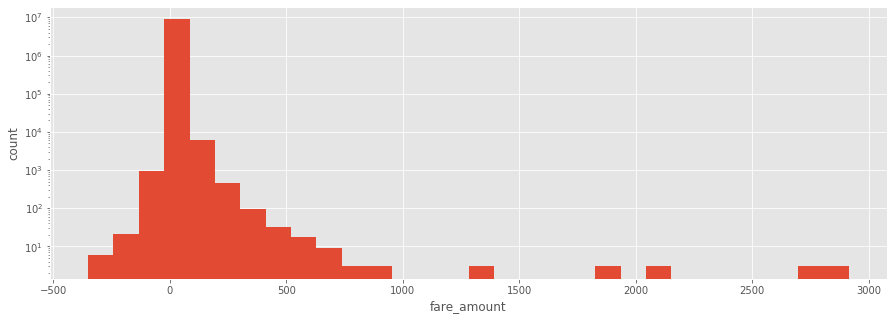

In [7]:
ax = df_dist['fare_amount'].hist(bins=30, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("fare_amount")
ax.set_ylabel("count")
plt.show()

**From the above plot it can be estimiated that fare amount is right skewed and indicates passengers are using green taxis for shorter trips as  fare amount is directly related to the time-and-distance fare calculated by the meter**

# 1.a.What do the following distributions tell us? tip amount?

In [8]:
df_dist1 = pd.read_sql_query('SELECT tip_amount FROM table_record', nyc_database)
df_dist1['tip_amount'].describe()

count    8.852139e+06
mean     1.201217e+00
std      2.242019e+00
min     -1.056000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      4.080000e+02
Name: tip_amount, dtype: float64

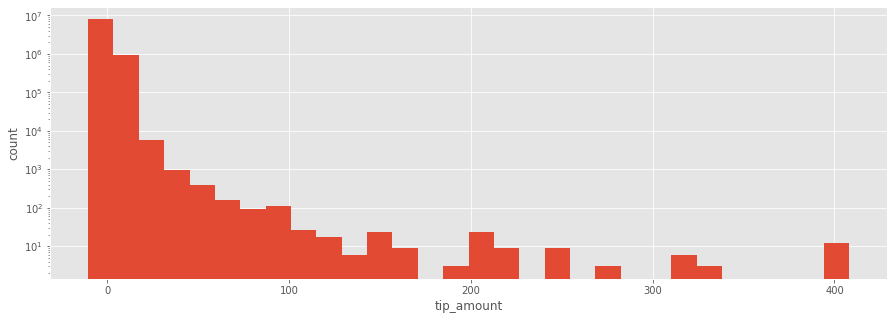

In [9]:
ax = df_dist1['tip_amount'].hist(bins=30, figsize=(15,5))
ax.set_yscale('log')
ax.set_xlabel("tip_amount")
ax.set_ylabel("count")
plt.show()

**From the above plot it can be estimiated that fare amount is right skewed and indicates passengers are  almost equaly using  credit card  and cash for payment** 

# 1.What do the following distributions tell us?
#### b.Number of passengers

In [10]:
df_dist2 = pd.read_sql_query('SELECT passenger_count FROM table_record', nyc_database)
df_dist2['passenger_count'].describe()

count    8.852139e+06
mean     1.361812e+00
std      1.033225e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

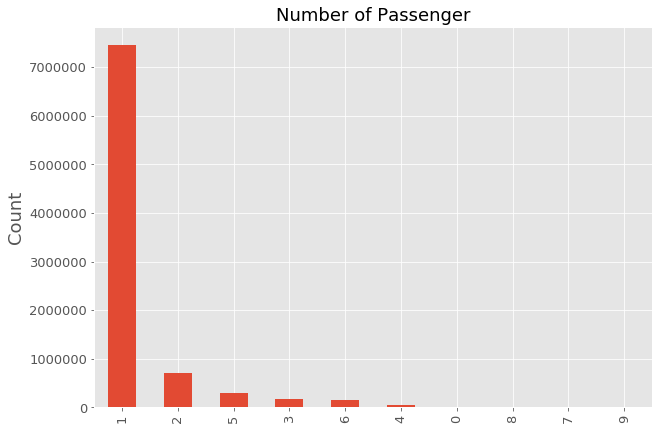

In [11]:
ax = df_dist2['passenger_count'].value_counts().plot(kind='bar', figsize=(10,7),
                                       fontsize=13)
ax.set_title("Number of Passenger", fontsize=18)
ax.set_ylabel("Count", fontsize=18);
ax.ticklabel_format(style='plain', axis='y')

**From the above chart shows usually passengers tend to travel alone followed by airport & usually customer travel in a standard fare category.**

#### c. Payment type?

In [12]:
df_dist3 = pd.read_sql_query('SELECT payment_type FROM table_record', nyc_database)
df_dist3['payment_type'].describe()

count    8.852139e+06
mean     1.512680e+00
std      5.250263e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      5.000000e+00
Name: payment_type, dtype: float64

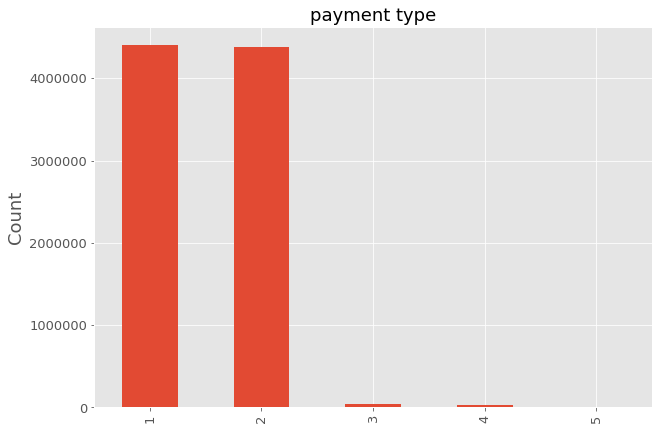

In [13]:
ax = df_dist3['payment_type'].value_counts().plot(kind='bar', figsize=(10,7),
                                       fontsize=13)
ax.set_title("payment type", fontsize=18)
ax.set_ylabel("Count", fontsize=18);
ax.ticklabel_format(style='plain', axis='y')

**Passengers are almost equaly using  credit card  and cash for payment as they are using green taxis for shorter trips**

# 2.0 What are the top 5 busiest time of the day?

In [14]:
df_pu = pd.read_sql_query('SELECT pickup_hour AS time, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY pickup_hour', nyc_database)
df_do = pd.read_sql_query('SELECT dropoff_hour AS time, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY dropoff_hour', nyc_database)
df_q2 = df_pu.merge(df_do, on="time")

In [29]:
#now we will visualise the data

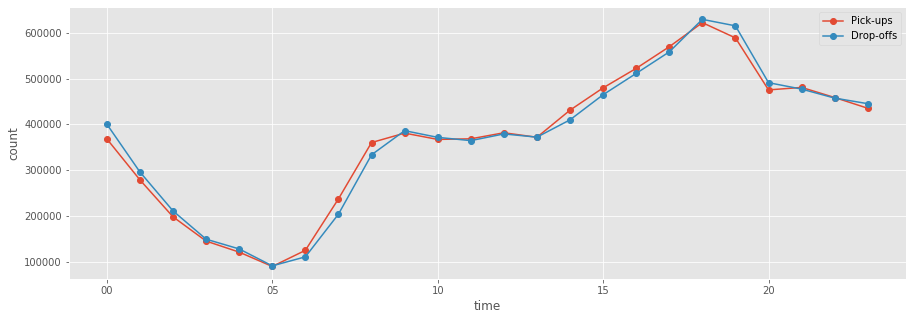

In [15]:
template = pd.DataFrame(["{0:0=2d}".format(x) for x in range(0,24)], columns=["time"])
df_q2 = df_q2.join(template.set_index("time"), how = 'outer', on=["time"]).fillna(0) \
                .groupby(["time"], as_index=False) \
                .agg({'PUcount': 'sum', 'DOcount': 'sum'}) \
                .rename(columns = {'PUcount':'Pick-ups', 'DOcount': 'Drop-offs'}) \
                .sort_values(by='time')

ax = df_q2.plot(x='time', y=['Pick-ups', 'Drop-offs'], kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("count")
plt.show()

**From the above graph it can be inferred that thetop 5 busiest times for both pickup and dropoffs time is
1st busiest time for both pickup and droffs  is :6PM
2nd busiest time  both pickup and droffs is : 7PM
3rd busiest time  for both pickup and droffs is :5PM
4th busiest time  for both tpickup and droffs is :4PM
5th busiest time for pickup and drop off is : 3PM**

# 3. What are the top 5 busiest locations in the city?

In [5]:
df_pu = pd.read_sql_query('SELECT PULocationID AS LocationID, count(*) AS PUcount \
                        FROM table_record \
                        GROUP BY PULocationID', nyc_database)
df_do = pd.read_sql_query('SELECT DOLocationID AS LocationID, count(*) AS DOcount \
                        FROM table_record \
                        GROUP BY DOLocationID', nyc_database)

In [6]:
#Location data including TLC taxi zone location IDs, location names and corresponding boroughs for each ID
sf = shapefile.Reader("shape/taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()

In [7]:
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [8]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [9]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")


In [10]:
# finding top 5 busiest locations in the city
template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])
df_q1 = pd.concat([df_pu, df_do]).join(template.set_index("LocationID"), how = 'outer', on=["LocationID"]).fillna(0) \
                                    .groupby(["LocationID"], as_index=False) \
                                    .agg({'PUcount': 'sum', 'DOcount': 'sum'})\
                                    .sort_values(by=['LocationID'])
df_q1['TOTALcount'] = df_q1['PUcount'] + df_q1['DOcount']
loc = df_loc[["LocationID", "zone", "borough"]]
df_q1 = df_q1.merge(loc, left_on="LocationID", right_on="LocationID")

PUcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['PUcount'].tolist()))
PUtop5 = df_q1.sort_values(by=['PUcount'], ascending=False).set_index("LocationID").head(5)
DOcount = dict(zip(df_q1['LocationID'].tolist(), df_q1['DOcount'].tolist()))
DOtop5 = df_q1.sort_values(by=['DOcount'], ascending=False).set_index("LocationID").head(5)

In [22]:
#PUtop5= pickup count of top5 and # Dotop5 = drop top 5 count
print('the top 5 busiest locations in the city for pickup are\n',PUtop5)
print("the top5 busiest locations in the city for the dropoff are\n",DOtop5)

the top 5 busiest locations in the city for pickup are
              PUcount   DOcount  TOTALcount               zone    borough
LocationID                                                              
74          551121.0  296595.0    847716.0  East Harlem North  Manhattan
41          498426.0  261765.0    760191.0     Central Harlem  Manhattan
75          462093.0  189456.0    651549.0  East Harlem South  Manhattan
7           460887.0  284046.0    744933.0            Astoria     Queens
82          391608.0  179655.0    571263.0           Elmhurst     Queens
the top5 busiest locations in the city for the dropoff are
              PUcount   DOcount  TOTALcount                  zone    borough
LocationID                                                                 
74          551121.0  296595.0    847716.0     East Harlem North  Manhattan
42          314988.0  293799.0    608787.0  Central Harlem North  Manhattan
7           460887.0  284046.0    744933.0               Astoria     

***The top 5 busiest locations are East Harlem North,Central Harlem,East Harlem South,Astoria and Elmhurst***

# 4.What are the top 5 busiest routes in the city?

In [13]:
df_q3 = pd.read_sql_query('SELECT PULocationID, DOLocationID, count(*) AS count \
                                 FROM table_record \
                                 GROUP BY PULocationID, DOLocationID', nyc_database)

***After extracting data from database and then arranged the information and show the top 5 busiest routes, the fact that it takes about 30 miles to drive across the whole New York City. I decided to use 30 as the number to split the trips into short or long distance trips.***

In [26]:
df_q3 = df_q3.merge(df_loc[["LocationID", "zone"]], left_on="PULocationID", right_on="LocationID") \
             .rename(columns={"zone":"pickup zone"}) \
             .merge(df_loc[["LocationID", "zone"]], left_on="DOLocationID", right_on="LocationID") \
             .rename(columns={"zone":"dropoff zone"})

In [29]:
top5_busy = df_q3.sort_values(by="PULocationID", ascending=False).head(5)
print(" the top five busiest routes for pickup zone is\n ",top5_busy[['pickup zone', 'dropoff zone','PULocationID']])

 the top five busiest routes for pickup zone is
            pickup zone     pickup zone               dropoff zone  \
6768   Yorkville West  Yorkville West             Yorkville West   
23799  Yorkville West  Yorkville West  Springfield Gardens South   
6293   Yorkville West  Yorkville West             West Concourse   
16395  Yorkville West  Yorkville West           Garment District   
25385  Yorkville West  Yorkville West      Upper West Side South   

                    dropoff zone  PULocationID  
6768              Yorkville West           263  
23799  Springfield Gardens South           263  
6293              West Concourse           263  
16395           Garment District           263  
25385      Upper West Side South           263  


In [23]:
top5_busy = df_q3.sort_values(by="dropoff zone", ascending=False).head(5)
print(" the top five busiest routes for pickup zone is\n ",top5_busy[['pickup zone', 'dropoff zone']])

 the top five busiest routes for pickup zone is
              pickup zone    dropoff zone
6376        JFK Airport  Yorkville West
6363            Gowanus  Yorkville West
6351  East Harlem South  Yorkville West
6352       East Tremont  Yorkville West
6353  East Williamsburg  Yorkville West


**From the above data Astoria is the busiest route for pickup and drop for shortest route from  the above data Washington Heights South to Marine Park/Mill Basin is the busiest route**

## 5.Can you characterize trips by attributes such as distance, fare, pickup point?

In [27]:
def trip_on(attr, rpr="count", kind='bar'):
    df_q3_Street_hail = pd.read_sql_query('SELECT '+attr+', count(*) as count \
                                    FROM table_record \
                                    WHERE trip_type <= 1 \
                                    GROUP BY '+attr, nyc_database)
    df_q3_Dispatch = pd.read_sql_query('SELECT '+attr+', avg(trip_distance) AS AVG_trip_distance, count(*) as count \
                                    FROM table_record \
                                    WHERE trip_type > 1 \
                                    GROUP BY '+attr, nyc_database)
    if rpr == "proportion":
        s = np.sum(df_q3_Street_hail['count'].values)
        df_q3_Street_hail['proportion'] = [float(x)/s for x in df_q3_Street_hail['count']]
        s = np.sum(df_q3_Dispatch['count'].values)
        df_q3_Dispatch['proportion'] = [float(x)/s for x in df_q3_Dispatch['count']]
    
    df_q3 = df_q3_Street_hail.merge(df_q3_Dispatch, on=attr, suffixes=["_Street_hail", "_Dispatch"]) \
                        .rename(columns={rpr+"_Street_hail":"Street_hail", rpr+"_Dispatch":"Dispatch"}) 
    ax = df_q3.plot(x=attr, y=['Street_hail', 'Dispatch'], kind=kind, figsize=(35,15),fontsize=18)
    ax.set_ylabel(rpr)
    ax.set_title(attr.replace("_", " ")+" trip_type")

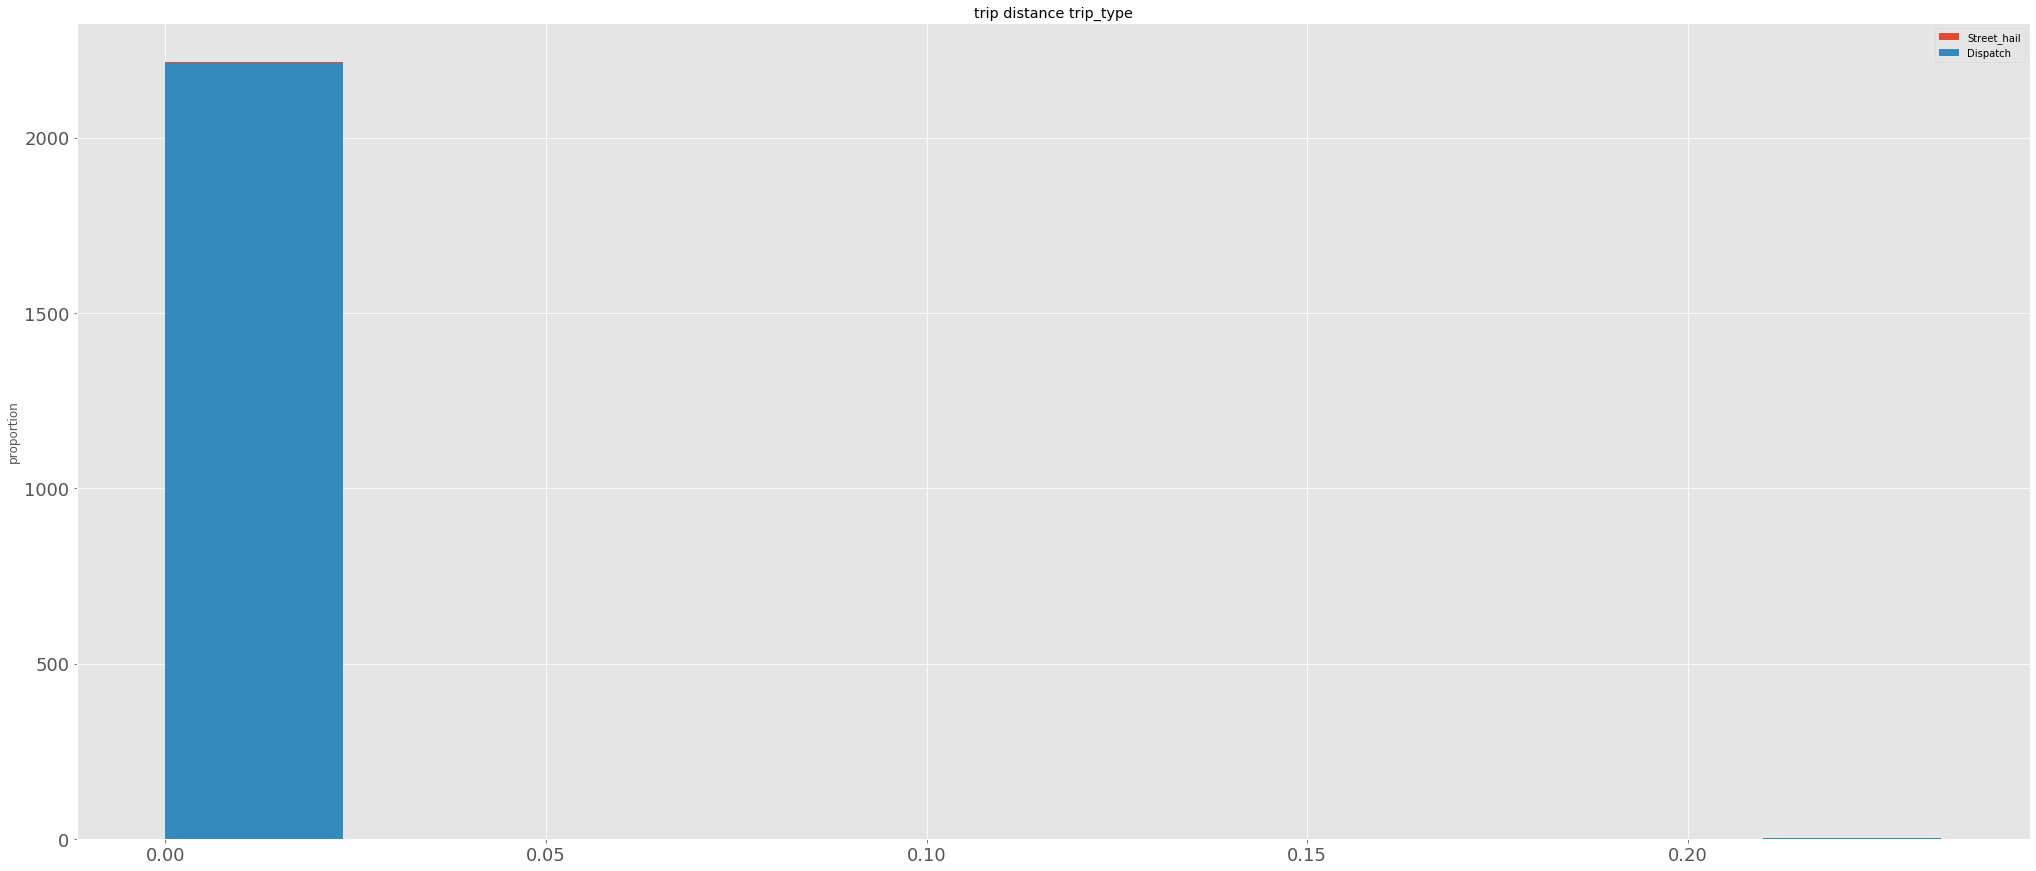

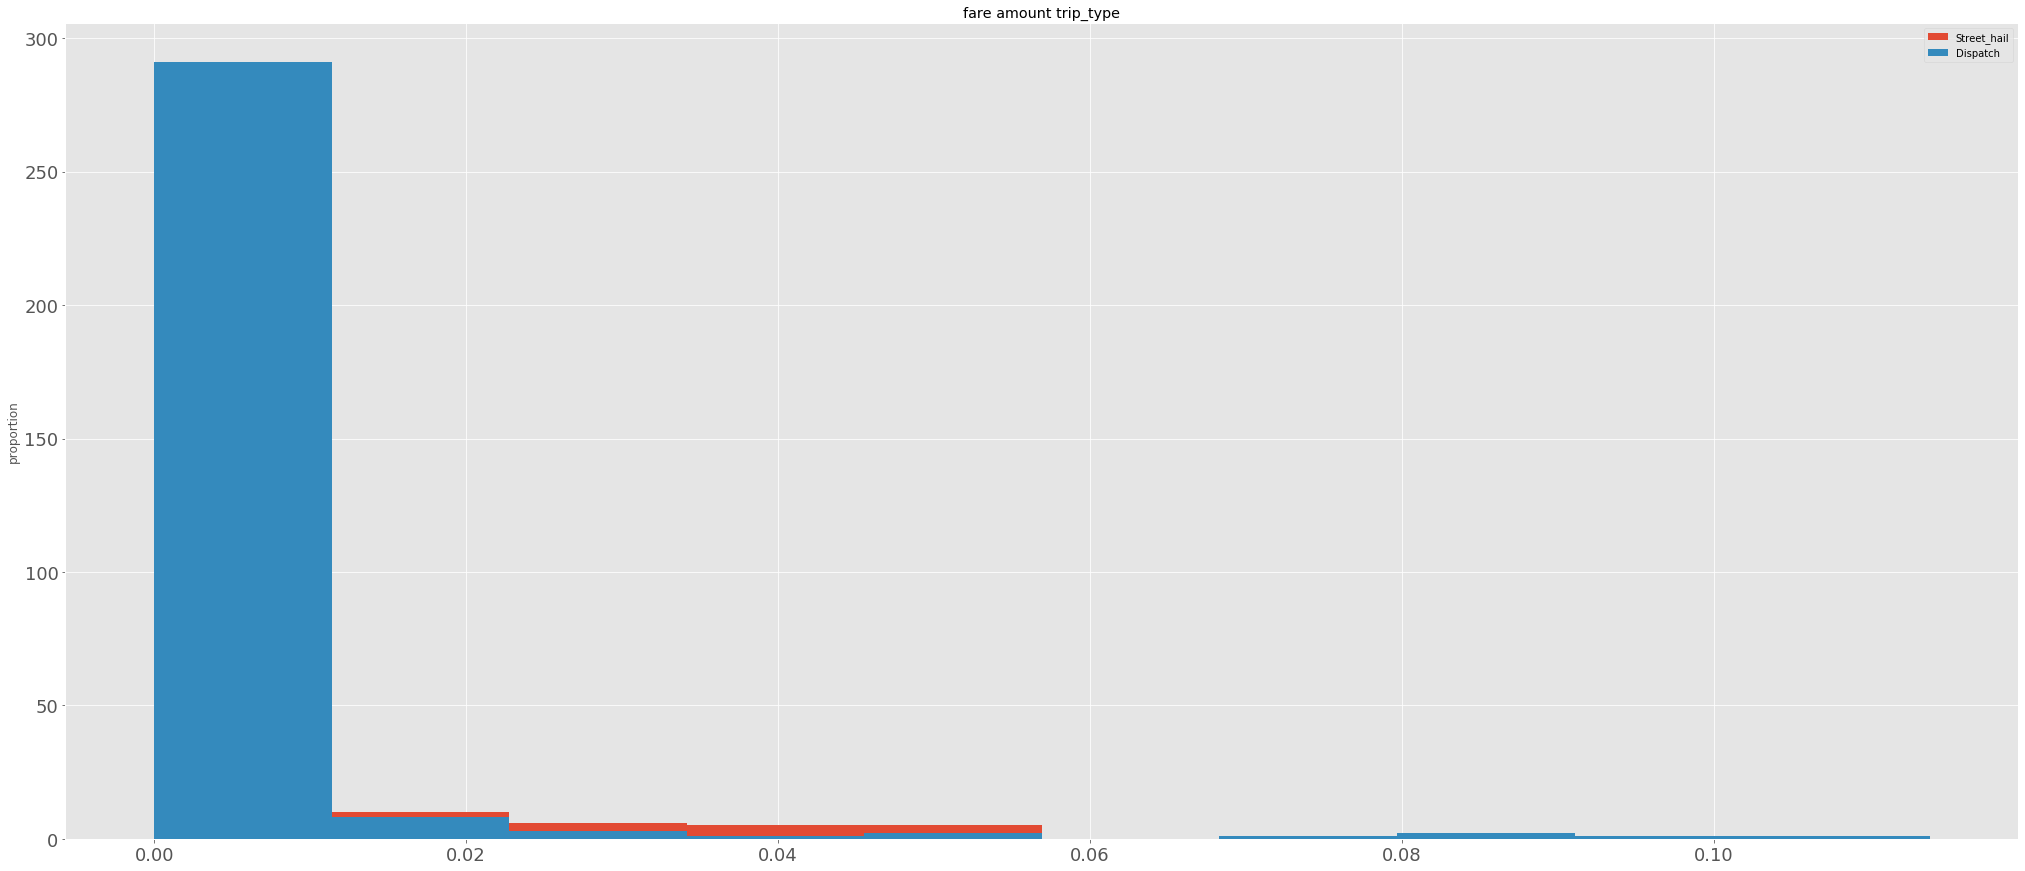

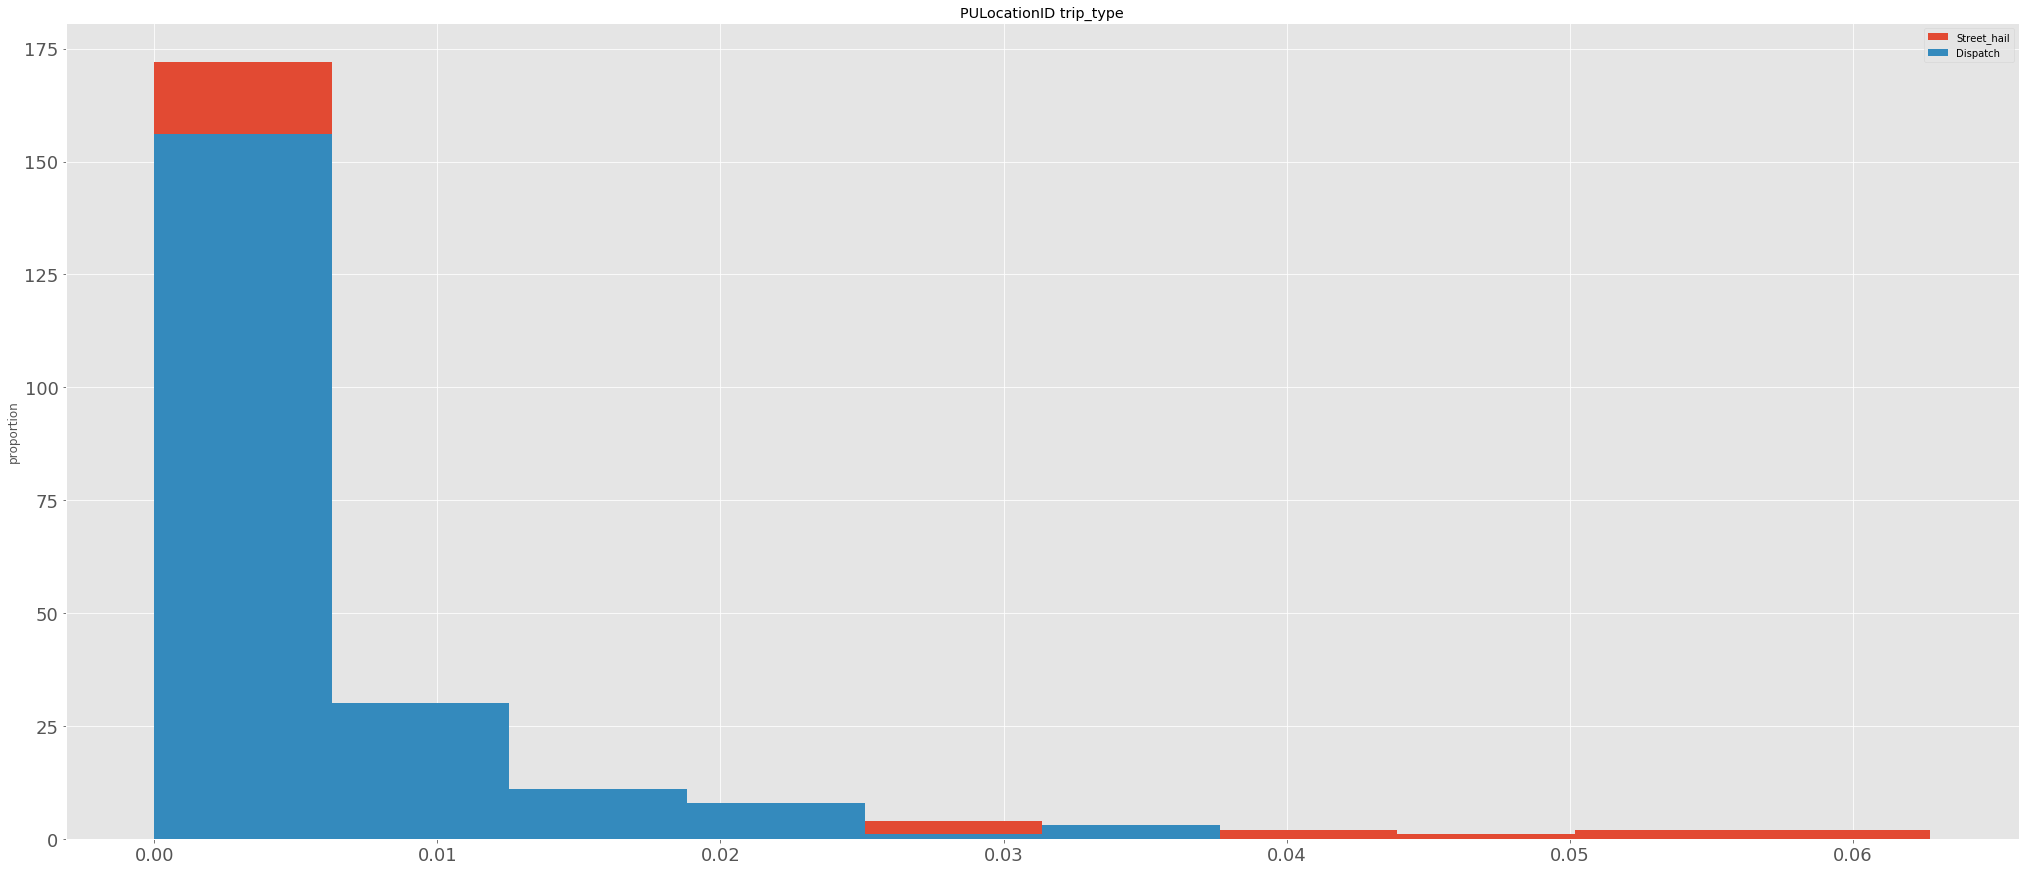

In [28]:
for attr in ["trip_distance", "fare_amount", "PULocationID"]:
    trip_on(attr, rpr="proportion", kind='hist')

**From the above histograms it can be inferred that the trip_distance is completely Dispatch type trip and for higher 
fare_ amounts the trip type is Dispatch and for lower fare amounts its both.From pickup_point we can infer that for first 10 locations the trip type is street hail type.**

# 6 Can you predict fare and tip amount of a trip?
#for this we create data frame by merging locations data frama and acutal data

In [32]:
df_dummy1 = pd.read_sql_query('SELECT pickup_hour,fare_amount,tip_amount,payment_type, trip_distance,passenger_count,PULocationID AS LocationID FROM table_record', nyc_database)

In [31]:
df_loc

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.023971e+06,266866.032718
259,260,0.133514,0.000422,Woodside,260,Queens,1.010063e+06,211298.529136
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.807446e+05,197628.272456
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.994435e+05,222247.381595


In [32]:
df_train=pd.merge(df_dummy1, df_loc, on='LocationID')

In [33]:
df_train

,pickup_hour,fare_amount,tip_amount,payment_type,trip_distance,passenger_count,LocationID,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude
0,00,13.0,0.00,2,2.63,1,223,223,0.166022,0.000764,Steinway,Queens,1.010330e+06,222885.452891
1,00,6.5,0.00,2,1.60,1,223,223,0.166022,0.000764,Steinway,Queens,1.010330e+06,222885.452891
2,00,6.0,1.46,1,0.97,1,223,223,0.166022,0.000764,Steinway,Queens,1.010330e+06,222885.452891
3,00,5.0,0.00,2,0.76,1,223,223,0.166022,0.000764,Steinway,Queens,1.010330e+06,222885.452891
4,00,21.0,4.46,1,6.53,2,223,223,0.166022,0.000764,Steinway,Queens,1.010330e+06,222885.452891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8883676,21,10.5,2.36,1,1.92,1,162,162,0.035270,0.000048,Midtown East,Manhattan,9.918767e+05,215015.150630
8883677,21,10.5,2.36,1,1.92,1,162,162,0.035270,0.000048,Midtown East,Manhattan,9.918767e+05,215015.150630
8883678,10,14.0,2.50,1,3.60,1,233,233,0.048036,0.000116,UN/Turtle Bay South,Manhattan,9.925680e+05,212203.983347
8883679,10,14.0,2.50,1,3.60,1,233,233,0.048036,0.000116,UN/Turtle Bay South,Manhattan,9.925680e+05,212203.983347


**Now i will upload test data of a trip to predict fare amount and tip amount. I will upload the excel file containg the trip details for which we have to predict the fare amount and tip amount.**

In [34]:
data_test=pd.read_excel("C:/Users/lenovo/Desktop/NYCtest.xlsx")

In [35]:
data_test

,pickup_hour,fare_amount,tip_amount,payment_type,trip_distance,passenger_count,LocationID,OBJECTID,Shape_Leng,Shape_Area,longitude,latitude
0,21,NaN,NaN,1,1.92,1,162,162,0.03527,0.000048,991876.7,215015.15063


In [36]:
df_train.corr()

,fare_amount,tip_amount,payment_type,trip_distance,passenger_count,LocationID,OBJECTID,Shape_Leng,Shape_Area,longitude,latitude
fare_amount,1.000000,0.397284,-0.133945,0.848070,0.011856,0.046183,0.046182,0.010505,0.035279,0.005660,-0.060465
tip_amount,0.397284,1.000000,-0.527908,0.413948,0.007225,0.033565,0.033551,-0.046373,-0.022469,-0.100742,-0.077342
payment_type,-0.133945,-0.527908,1.000000,-0.128114,-0.005425,-0.018299,-0.018276,0.080636,0.064377,0.141255,0.068898
trip_distance,0.848070,0.413948,-0.128114,1.000000,0.011455,0.057452,0.057451,0.016313,0.037646,0.022318,-0.047123
passenger_count,0.011856,0.007225,-0.005425,0.011455,1.000000,0.022439,0.022440,0.024053,0.016673,0.006017,-0.019782
LocationID,0.046183,0.033565,-0.018299,0.057452,0.022439,1.000000,1.000000,0.152673,0.200381,0.110078,0.036328
OBJECTID,0.046182,0.033551,-0.018276,0.057451,0.022440,1.000000,1.000000,0.152576,0.200314,0.110165,0.036326
Shape_Leng,0.010505,-0.046373,0.080636,0.016313,0.024053,0.152673,0.152576,1.000000,0.873575,0.511573,0.022787
Shape_Area,0.035279,-0.022469,0.064377,0.037646,0.016673,0.200381,0.200314,0.873575,1.000000,0.430534,-0.026706
longitude,0.005660,-0.100742,0.141255,0.022318,0.006017,0.110078,0.110165,0.511573,0.430534,1.000000,0.190389


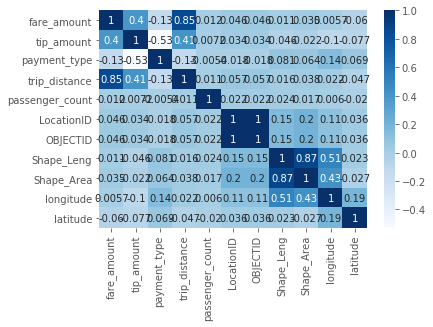

In [37]:
corr = df_train.corr() 
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()

**From the above correlation it can be inferred that fare amount is highly correlated on trip distance and tip amount.
Tip amount is highly correlated on trip dsitance and fare amount**
**For payment type is highly negatively correlated for fare amount and tip amount**

In [67]:
#Data cleaning by dropping zones and Brough

In [45]:
df_train_1=df_train.drop(["zone","borough"],axis=1)

In [46]:
df_train_1.head()

,pickup_hour,fare_amount,tip_amount,payment_type,trip_distance,passenger_count,LocationID,OBJECTID,Shape_Leng,Shape_Area,longitude,latitude
0,00,13.0,0.00,2,2.63,1,223,223,0.166022,0.000764,1.010330e+06,222885.452891
1,00,6.5,0.00,2,1.60,1,223,223,0.166022,0.000764,1.010330e+06,222885.452891
2,00,6.0,1.46,1,0.97,1,223,223,0.166022,0.000764,1.010330e+06,222885.452891
3,00,5.0,0.00,2,0.76,1,223,223,0.166022,0.000764,1.010330e+06,222885.452891
4,00,21.0,4.46,1,6.53,2,223,223,0.166022,0.000764,1.010330e+06,222885.452891


In [61]:
X_train=df_train_1.drop(["fare_amount","tip_amount"],axis=1)
X_test  = data_test.drop(["fare_amount","tip_amount"], axis=1).copy()

In [62]:
Y_train = df_train["fare_amount"]

In [63]:
Y_train1=df_train["tip_amount"]

In [50]:
dtr = DecisionTreeRegressor() 
dtr.fit(X_train, Y_train) 
acc_dtr=round(dtr.score(X_train,Y_train)*100,2)
print("the accuracy of decision tree regression is :",acc_dtr)

the accuracy of decision tree regression is : 88.65


In [52]:
lr=LinearRegression()
lasso = Lasso()
ridge = Ridge()
lr.fit(X_train, Y_train) 
lasso.fit(X_train, Y_train) 
ridge.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [53]:
acc_lr=round(lr.score(X_train,Y_train)*100,2)
print("the accuracy of linear regression is :",acc_lr)
acc_lasso=round(lasso.score(X_train,Y_train)*100,2)
print("the accuracy of lasso regression is :",acc_lasso)
acc_ridge=round(ridge.score(X_train,Y_train)*100,2)
print("the accuracy of ridge regression is :",acc_ridge)

the accuracy of linear regression is : 72.06
the accuracy of lasso regression is : 71.84
the accuracy of ridge regression is : 72.05


In [64]:
# so the accuracy of decission tree is 88.6 we will use decision tree regression for prediction on test data
y_pred_dtr = dtr.predict(X_test)
print("the fare amount for given trip is", y_pred_dtr)

the fare amount for given trip is [10.5]


**The fare amount for the given trip is 10.5.Now we will predict tip amount in the similar lines**

In [55]:
dtr1 = DecisionTreeRegressor() 
dtr1.fit(X_train, Y_train1) 
acc_dtr1=round(dtr1.score(X_train,Y_train1)*100,2)
print("the accuracy of decision tree regression is :",acc_dtr1)

the accuracy of decision tree regression is : 84.45


In [56]:
lr=LinearRegression()
lasso = Lasso()
ridge = Ridge()
lr.fit(X_train, Y_train1) 
lasso.fit(X_train, Y_train1) 
ridge.fit(X_train, Y_train1)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [57]:
acc_lr=round(lr.score(X_train,Y_train1)*100,2)
print("the accuracy of linear regression is :",acc_lr)
acc_lasso=round(lasso.score(X_train,Y_train1)*100,2)
print("the accuracy of lasso regression is :",acc_lasso)
acc_ridge=round(ridge.score(X_train,Y_train1)*100,2)
print("the accuracy of ridge regression is :",acc_ridge)

the accuracy of linear regression is : 40.3
the accuracy of lasso regression is : 16.02
the accuracy of ridge regression is : 40.29


**so the accuracy of decission tree is 84.2 we will use decision tree regression for prediction on test data The accuracy of decision tree is less but we going with this only as random forest and Xgboosting are consuming lot of time for prediciton**

In [65]:
y_pred_dtr1 = dtr1.predict(X_test)
print("the tip amount for given trip is", y_pred_dtr1)

the tip amount for given trip is [2.36]


**The tip amount is 2.36. Both the tip amount and fare amount are exactly matching with the 5922450	row values as we have used that row of trip as our test data to test our models*. Hence both the fare amount and tip amount for this particular trip is 10.5 and 2.36**

# 7.If you are a taxi owner, how would you maximize earnings in a day?

In [102]:
df_train['pickup_hour'] = df_train['pickup_hour'].replace(['00'],'0')

Text(0.5, 1.0, 'Distribution of trip distance by pickup hour')

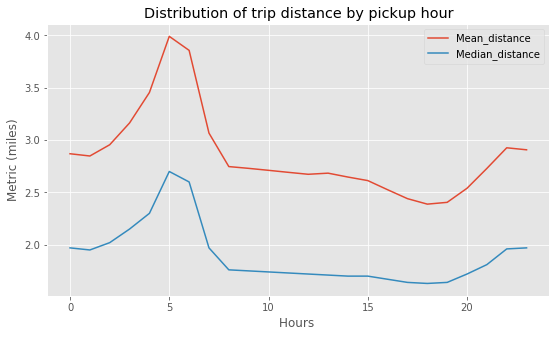

In [103]:
fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate Trip_distance by hour
table1 = df_train.pivot_table(index='pickup_hour', values='trip_distance',aggfunc=('mean','median')).reset_index()
# rename columns
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours ')
plt.title('Distribution of trip distance by pickup hour')

**From the above it can be inferred that the long distance travels is in early morning hours and then after 8pm in the night**

<Figure size 1080x360 with 0 Axes>

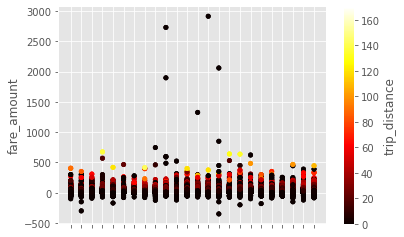

In [133]:
plt.figure(figsize=(15,5))
df_train.plot.scatter(x='pickup_hour',y='fare_amount',c='trip_distance',colormap='hot')
plt.xlabel=('pickup_hour')
plt.ylabel=('fare_amount')

**The figure above makes sense: the best earnings happen during rush-hour, especially around noon,As a taxi driver, a fraction of our earnings go to the taxi company, so we might be interested  at which times customers tip the mostSo let’s produce a similar plot, this time displaying tip amount**

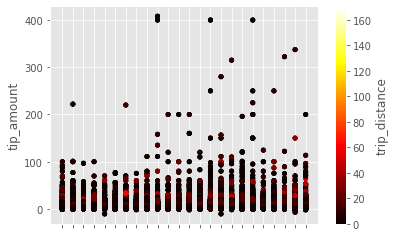

In [38]:
df_train.plot.scatter(x='pickup_hour',y='tip_amount',c='trip_distance',colormap='hot')

***From the above figure it can be seen that tip amountdensity is high between 11 AM to 7PM. SO from both fare amount and tip amount I can say that as taxi driver I will prefer between 12 noon to 6PM for earning maximum profit***

### 8  If you own 10 taxis, how would you maximize your earnings?

***From the above figure and from the analysis of busiest routes, locations,trip distances and inorder to maximize my earnings I will allocate 3 taxis in busiest routes, 3 taxies in the early hours as trip dsitance is high due to passengers goint to airport.
I will allocate 3 more taxis in the rush hours that is in the noon, 2 in busiest routes, 2 in busiest locations and 1 for normal operation***